## Imports and setup

Monto l'unità di Google Drive in cui è salvato il dataset

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


imports

In [8]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub

import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras import layers

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
tf.config.list_physical_devices('GPU')


TF version: 2.6.0
Hub version: 0.12.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [11]:
model_name = "efficientnetv2-s" 
model_handle = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/feature_vector/1"
 
print(f"Selected model: {model_name} : {model_handle}")

IMAGE_SIZE = (384, 384)
print(f"Input image size {IMAGE_SIZE}")

BATCH_SIZE =  16

Selected model: efficientnetv2-s : https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/feature_vector/1
Input image size (384, 384)


Selezione del percorso nel drive all'interno del quale si trovano le immagini di training e testing.
Creazione dei DataGenerators, suddividendo il training set in validation e training e preprocessando le immagini.
Definizione dei relativi set.

In [16]:
#Percorsi di training e test set
train_path="/content/gdrive/My Drive/datasets/buildings/train"
test_path="/content/gdrive/My Drive/datasets/buildings/test"

#Creazione data generators
train_datagen = ImageDataGenerator(validation_split= 0.1,
                                    rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)


#Creazione datasets: validation set di 238 immagini, training set di 2400, test set di 250
validation_set = train_datagen.flow_from_directory(train_path, 
                                                  target_size = (384, 384),
                                                  subset='validation')

training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (384, 384),
                                                 batch_size = 16,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (384, 384),
                                            batch_size = 16,
                                            class_mode = 'categorical')

Found 238 images belonging to 5 classes.
Found 2400 images belonging to 5 classes.
Found 250 images belonging to 5 classes.


## Building and training the model

Analisi del modello adottato: efficientnet_v2

In [13]:
do_fine_tuning = False

print("Building model", model_name)
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(model_handle, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(5,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model efficientnetv2-s
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              20331360  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 6405      
Total params: 20,337,765
Trainable params: 6,405
Non-trainable params: 20,331,360
_________________________________________________________________


Ottimizzazione SGD via Keras (stochastic gradient descent), definizione dell'accuracy come metrica. Loss calcolata mediante crossentropy.

In [14]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

Predizione effettiva + rappresentazione mediante MatPlotLib di loss e accuracy.

In [17]:
hist = model.fit(
    training_set,
    epochs=10, 
    validation_data=validation_set,
    ).history

Epoch 1/10
150/150 [==============================] - 820s 5s/step - loss: 0.6652 - accuracy: 0.8817 - val_loss: 0.5121 - val_accuracy: 0.9580
Epoch 2/10
150/150 [==============================] - 175s 1s/step - loss: 0.5334 - accuracy: 0.9367 - val_loss: 0.5003 - val_accuracy: 0.9664
Epoch 3/10
150/150 [==============================] - 175s 1s/step - loss: 0.5228 - accuracy: 0.9458 - val_loss: 0.4820 - val_accuracy: 0.9748
Epoch 4/10
150/150 [==============================] - 176s 1s/step - loss: 0.5158 - accuracy: 0.9533 - val_loss: 0.4842 - val_accuracy: 0.9748
Epoch 5/10
150/150 [==============================] - 177s 1s/step - loss: 0.5104 - accuracy: 0.9521 - val_loss: 0.4818 - val_accuracy: 0.9706
Epoch 6/10
150/150 [==============================] - 177s 1s/step - loss: 0.5040 - accuracy: 0.9583 - val_loss: 0.4742 - val_accuracy: 0.9748
Epoch 7/10
150/150 [==============================] - 176s 1s/step - loss: 0.5042 - accuracy: 0.9546 - val_loss: 0.4766 - val_accuracy: 0.9748

## Testing

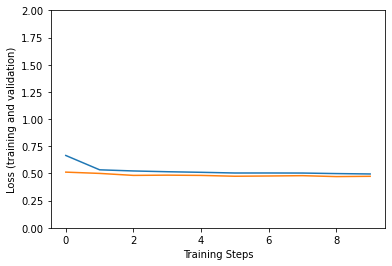

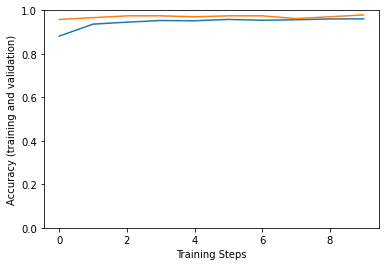

In [18]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

Calcolo "a mano" delle predizioni corrette ottenute, si ottiene una correttezza del 96%.

In [19]:
class_names=["Arch_Bridges", "Castles", "Churches", "Towers", "Triumphal_Arches"]
correctPred = 0
pred = 0

while pred < 250: 
  pred +=1
  x, y = next(iter(test_set))
  image = x[0, :, :, :]
  true_index = np.argmax(y[0])

  # Expand the validation image to (1, 384, 384, 3) before predicting the label
  prediction_scores = model.predict(np.expand_dims(image, axis=0))
  predicted_index = np.argmax(prediction_scores)

  if class_names[true_index] == class_names[predicted_index]:
    correctPred+=1
  #print("True label: " + class_names[true_index])
  #print("Predicted label: " + class_names[predicted_index])

print("{}/{} correct guesses = {}".format(correctPred, pred, correctPred*100/pred))

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (108014142 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


241/250 correct guesses = 96.4


## Convert to TFLite

Salvataggio del modello.

In [20]:
saved_model_path = f"/content/gdrive/My Drive/TrainedModels_effNetQuant/saved_model_384_"
tf.saved_model.save(model, saved_model_path)

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/TrainedModels_effNetQuant/saved_model_384_/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/TrainedModels_effNetQuant/saved_model_384_/assets


Conversione del modello in TFlite, con calibrazione su 60 immagini di esempio.

In [21]:
optimize_lite_model = True 
num_calibration_examples = 60 
representative_dataset = None

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
if optimize_lite_model:
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  if representative_dataset: 
    converter.representative_dataset = representative_dataset
lite_model_content = converter.convert()

with open(f"/content/gdrive/My Drive/TrainedModels_effNetQuant/saved_model_384_.tflite", "wb") as f: 
  f.write(lite_model_content)
print("Wrote %sTFLite model of %d bytes." %
      ("optimized " if optimize_lite_model else "", len(lite_model_content)))

Wrote optimized TFLite model of 22830064 bytes.


Definizione del modello tramite l'interprete. Definizione di una funzione Numpy to Numpy per ottenere il tensore del modello tflite.

In [22]:
interpreter = tf.lite.Interpreter(model_content=lite_model_content)

def lite_model(images):
  interpreter.allocate_tensors()
  interpreter.set_tensor(interpreter.get_input_details()[0]['index'], images)
  interpreter.invoke()
  return interpreter.get_tensor(interpreter.get_output_details()[0]['index'])

In [25]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print(input_details)
print(input_details)

[{'name': 'serving_default_input_2:0', 'index': 0, 'shape': array([  1, 384, 384,   3], dtype=int32), 'shape_signature': array([ -1, 384, 384,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'serving_default_input_2:0', 'index': 0, 'shape': array([  1, 384, 384,   3], dtype=int32), 'shape_signature': array([ -1, 384, 384,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


## TFLite testing

Analisi delle performance del modello TFlite in relazione al modello iniziale. Rispetto al modello iniziale, la concordanza è del 98% circa.

In [26]:
import time

start_time = time.time()
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (384, 384),
                                            batch_size = 16,
                                            class_mode = 'categorical')
num_eval_examples = 250 
eval_dataset = ((image, label) 
                for batch in test_set
                for (image, label) in zip(*batch))
count = 0
count_lite_tf_agree = 0
count_lite_correct = 0
for image, label in eval_dataset:
  probs_lite = lite_model(image[None, ...])[0]
  probs_tf = model(image[None, ...]).numpy()[0]
  y_lite = np.argmax(probs_lite)
  y_tf = np.argmax(probs_tf)
  y_true = np.argmax(label)
  count +=1
  if y_lite == y_tf: count_lite_tf_agree += 1
  if y_lite == y_true: count_lite_correct += 1
  if count >= num_eval_examples: break
print("TF Lite model agrees with original model on %d of %d examples (%g%%)." %
      (count_lite_tf_agree, count, 100.0 * count_lite_tf_agree / count))
print("TF Lite model is accurate on %d of %d examples (%g%%)." %
      (count_lite_correct, count, 100.0 * count_lite_correct / count))

print("duration: {} seconds".format(start_time - time.time()))

Found 250 images belonging to 5 classes.


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (108014142 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


TF Lite model agrees with original model on 246 of 250 examples (98.4%).
TF Lite model is accurate on 240 of 250 examples (96%).
duration: -6237.430104732513 seconds


Tentativo del 26 settembre: caricamento del modello tflite e tentativo di visualizzare il suo comportamento
*Corinna*



In [27]:
# Load SavedModel

class_model = hub.load(f"/content/gdrive/My Drive/TrainedModels_effNetQuant/saved_model_384_")
print(class_model)

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f0c7e8be3d0>


In [28]:
# Get images and labels batch from validation dataset generator

val_image_batch, val_label_batch = next(iter(validation_set))
true_label_ids = np.argmax(val_label_batch, axis=-1)

print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (32, 384, 384, 3)


In [29]:
tf_model_predictions = class_model(val_image_batch)
print("Prediction results shape:", tf_model_predictions.shape)

Prediction results shape: (32, 5)


In [30]:
# Learn about dataset labels

dataset_labels = sorted(training_set.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

['Arch_Bridges' 'Castles' 'Churches' 'Towers' 'Triumphal_Arches']


In [31]:
# Convert prediction results to Pandas dataframe, for better visualization
import pandas as pd

tf_pred_dataframe = pd.DataFrame(tf_model_predictions.numpy())
tf_pred_dataframe.columns = dataset_labels

print("Prediction results for the first elements")
tf_pred_dataframe.head()

Prediction results for the first elements


,Arch_Bridges,Castles,Churches,Towers,Triumphal_Arches
0,-1.421892,-1.206692,0.478644,2.774286,-0.548856
1,3.189573,-0.891444,-0.951219,-0.890115,-0.713609
2,-0.177665,2.998107,-1.471386,0.384982,-0.796224
3,-1.118155,-1.394247,2.868975,0.937935,-1.310840
4,-0.763996,-1.021366,4.549083,-1.491447,0.670021


In [32]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]

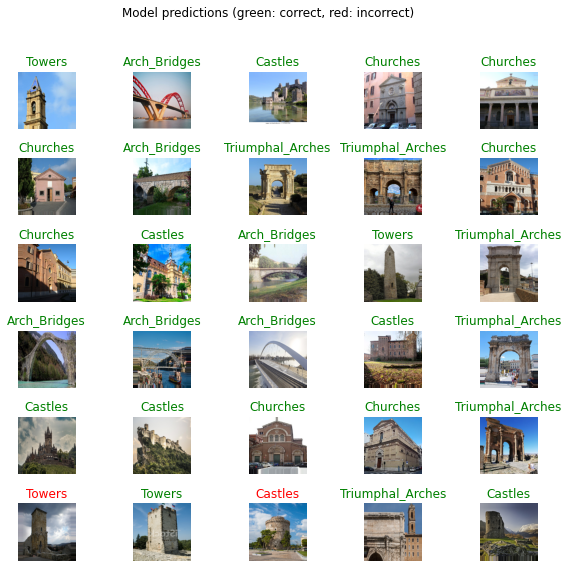

In [33]:
# Print images batch and labels predictions

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [34]:
TFLITE_QUANT_MODEL = f"/content/gdrive/My Drive/TrainedModels_effNetQuant/saved_model_384_.tflite"

In [35]:
# Load quantized TFLite model
tflite_interpreter_quant = tf.lite.Interpreter(model_path=TFLITE_QUANT_MODEL)

# Learn about its input and output details
input_details = tflite_interpreter_quant.get_input_details()
output_details = tflite_interpreter_quant.get_output_details()

# Resize input and output tensors to handle batch of 32 images
tflite_interpreter_quant.resize_tensor_input(input_details[0]['index'], (32, 384, 384, 3))
tflite_interpreter_quant.resize_tensor_input(output_details[0]['index'], (32, 5))
tflite_interpreter_quant.allocate_tensors()

input_details = tflite_interpreter_quant.get_input_details()
output_details = tflite_interpreter_quant.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

# Run inference
tflite_interpreter_quant.set_tensor(input_details[0]['index'], val_image_batch)

tflite_interpreter_quant.invoke()

tflite_q_model_predictions = tflite_interpreter_quant.get_tensor(output_details[0]['index'])
print("\nPrediction results shape:", tflite_q_model_predictions.shape)

== Input details ==
name: serving_default_input_2:0
shape: [ 32 384 384   3]
type: <class 'numpy.float32'>

== Output details ==
name: StatefulPartitionedCall:0
shape: [32  5]
type: <class 'numpy.float32'>

Prediction results shape: (32, 5)


In [36]:
# Convert prediction results to Pandas dataframe, for better visualization
import pandas as pd 

tflite_q_pred_dataframe = pd.DataFrame(tflite_q_model_predictions)
tflite_q_pred_dataframe.columns = dataset_labels

print("Quantized TFLite model prediction results for the first elements")
tflite_q_pred_dataframe.head()

Quantized TFLite model prediction results for the first elements


,Arch_Bridges,Castles,Churches,Towers,Triumphal_Arches
0,-1.446824,-1.261484,0.459883,2.783061,-0.404919
1,3.242488,-0.942807,-0.943531,-0.987762,-0.742291
2,-0.222142,2.988315,-1.302867,0.157928,-0.764809
3,-1.176474,-1.487572,2.854887,1.137654,-1.216693
4,-0.726875,-1.001327,4.596606,-1.607045,0.659262


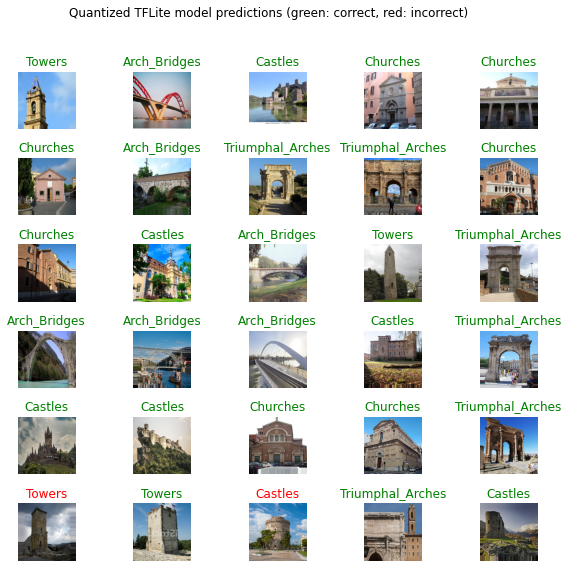

In [37]:
# Print images batch and labels predictions for TFLite Model

tflite_q_predicted_ids = np.argmax(tflite_q_model_predictions, axis=-1)
tflite_q_predicted_labels = dataset_labels[tflite_q_predicted_ids]
tflite_q_label_id = np.argmax(val_label_batch, axis=-1)

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if tflite_q_predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(tflite_q_predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Quantized TFLite model predictions (green: correct, red: incorrect)")

Analisi delle differenze tra i vari modelli. Non sembrano essercene

In [38]:
# Concatenate results from all models

all_models_dataframe = pd.concat([tf_pred_dataframe, 
                                  tflite_q_pred_dataframe], 
                                 keys=['TF Model', 'TFLite quantized'],
                                 axis='columns')
all_models_dataframe.head()

TF Model                      ... TFLite quantized                           
  Arch_Bridges   Castles  Churches  ...         Churches    Towers Triumphal_Arches
0    -1.421892 -1.206692  0.478644  ...         0.459883  2.783061        -0.404919
1     3.189573 -0.891444 -0.951219  ...        -0.943531 -0.987762        -0.742291
2    -0.177665  2.998107 -1.471386  ...        -1.302867  0.157928        -0.764809
3    -1.118155 -1.394247  2.868975  ...         2.854887  1.137654        -1.216693
4    -0.763996 -1.021366  4.549083  ...         4.596606 -1.607045         0.659262

[5 rows x 10 columns]

In [39]:
# Swap columns to hava side by side comparison

all_models_dataframe = all_models_dataframe.swaplevel(axis='columns')[tflite_q_pred_dataframe.columns]
all_models_dataframe.head()

Arch_Bridges                   ... Triumphal_Arches                 
      TF Model TFLite quantized  ...         TF Model TFLite quantized
0    -1.421892        -1.446824  ...        -0.548856        -0.404919
1     3.189573         3.242488  ...        -0.713609        -0.742291
2    -0.177665        -0.222142  ...        -0.796224        -0.764809
3    -1.118155        -1.176474  ...        -1.310840        -1.216693
4    -0.763996        -0.726875  ...         0.670021         0.659262

[5 rows x 10 columns]

In [40]:
def highlight_diff(data, color='yellow'):
    attr = 'background-color: {}'.format(color)
    other = data.xs('TF Model', axis='columns', level=-1)
    return pd.DataFrame(np.where(data.ne(other, level=0), attr, ''),
                        index=data.index, columns=data.columns)

all_models_dataframe.style.apply(highlight_diff, axis=None)

In [41]:
# Concatenation of argmax and max value for each row
def max_values_only(data):
  argmax_col = np.argmax(data, axis=1).reshape(-1, 1)
  max_col = np.max(data, axis=1).reshape(-1, 1)
  return np.concatenate([argmax_col, max_col], axis=1)

# Build simplified prediction tables
tf_model_pred_simplified = max_values_only(tf_model_predictions)
tflite_q_model_pred_simplified = max_values_only(tflite_q_model_predictions)

In [42]:
# Build DataFrames and present example
columns_names = ["Label_id", "Confidence"]
tf_model_simple_dataframe = pd.DataFrame(tf_model_pred_simplified)
tf_model_simple_dataframe.columns = columns_names

tflite_q_model_simple_dataframe = pd.DataFrame(tflite_q_model_pred_simplified)
tflite_q_model_simple_dataframe.columns = columns_names

tf_model_simple_dataframe.head()

,Label_id,Confidence
0,3.0,2.774286
1,0.0,3.189573
2,1.0,2.998107
3,2.0,2.868975
4,2.0,4.549083


In [43]:
# Concatenate results from all models
all_models_simple_dataframe = pd.concat([tf_model_simple_dataframe, 
                                         tflite_q_model_simple_dataframe], 
                                        keys=['TF Model', 'TFLite quantized'],
                                        axis='columns')

# Swap columns for side-by-side comparison
all_models_simple_dataframe = all_models_simple_dataframe.swaplevel(axis='columns')[tf_model_simple_dataframe.columns]

# Highlight differences
all_models_simple_dataframe.style.apply(highlight_diff, axis=None)